# Tool results comparison on IMG/VR4
Following up on the prep work in [`imgvr4_prep_jobs.ipynb`](./imgvr4_prep_jobs.ipynb), we'll now test the different aligners/search outputs. 
Unlike the similar notebook for simulated data, here we do not have a "ground truth" (we can't tell false and true positives (spacer-protospacer pairs) are not real or spurious).  
*Note*: We will treat mismatches as total number of non-matching positions plus all gap positions - i.e. edit distance.  

We'll use functions from `bench.py` and `utils.functions.py` to read the outputs, filter them, and compare them.  

In [1]:
import os
os.chdir('/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/')
import matplotlib.pyplot as plt
import upsetplot as up
import numpy as np
import polars as pl
pl.Config(tbl_rows=50)

# need to disable future deprecation warrnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


from bench import *
from bench.utils.functions import *


args = DebugArgs()
args.results_dir = 'results/real_data/'
args.threads = 12
args.contigs_file = 'imgvr4_data/crispr-host-prediction/IMGVR_all_nucleotides-high_confidence_nr.fna'
args.spacers_file = 'imgvr4_data/crispr-host-prediction/crispr-db/rm_duped_spacers.fna'
spacers = read_fasta(args.spacers_file)
spacer_lendf = pl.DataFrame({"spacer_id": spacers.keys(), "length": [len(seq) for seq in spacers.values()]})
tools = populate_tools(args, spacer_lendf=spacer_lendf)

Next, we'll prefilter the sam files to remove unmapped reads and reads with more than 3 mismatches.  
We will make sure of this again later but initially we'll use sambamba as it is faster than the python version.   
The python fucntion used  internally calls `add_sqlines_sam`, which verifies that the SAM files are formatted correctly.  

In [3]:
for tool in tools.values():
    if tool["output_file"].endswith('.sam'):
        print("prefiltering", tool["output_file"])
        prefilter_sam_with_sambamba(input_sam=tool["output_file"],output_sam= tool["output_file"].replace('.sam', '_prefiltered.sam'), max_mismatches=3, threads=4)
        tool["output_file"] = tool["output_file"].replace('.sam', '_prefiltered.sam')

prefiltering results/real_data//raw_outputs//bowtie1_output.sam
prefiltering results/real_data//raw_outputs//bowtie2_output.sam
prefiltering results/real_data//raw_outputs//minimap2_output.sam
prefiltering results/real_data//raw_outputs//bbmap_skimmer_output.sam
prefiltering results/real_data//raw_outputs//strobealign_output.sam
prefiltering results/real_data//raw_outputs//mummer4_output.sam


Next we'll read the results from the filtered SAM and tabular-output files.  We will again filter the alignments allowing up to 3 mismatches, this time counting gaps as non-matches.  

In [3]:
tools_results = read_results(tools, max_mismatches=3, spacer_lendf=spacer_lendf)


Reading results for bowtie1...
File size: 10760.11 MB
 output file  results/real_data//raw_outputs//bowtie1_output_prefiltered.sam exists
sam file looks right


Parsing SAM file: 56925177it [07:28, 127012.18it/s]
/clusterfs/jgi/groups/science/homes/uneri/.micromamba/envs/base_env/lib/python3.10/functools.py:889: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  return dispatch(args[0].__class__)(*args, **kw)



Reading results for bowtie2...
File size: 8706.93 MB
 output file  results/real_data//raw_outputs//bowtie2_output_prefiltered.sam exists
sam file looks right


Parsing SAM file: 37836309it [05:47, 108826.40it/s]



Reading results for minimap2...
File size: 387.42 MB
 output file  results/real_data//raw_outputs//minimap2_output_prefiltered.sam exists
sam file looks right


Parsing SAM file: 12859it [00:06, 1862.45it/s]



Reading results for bbmap_skimmer...
File size: 2584.18 MB
 output file  results/real_data//raw_outputs//bbmap_skimmer_output_prefiltered.sam exists
sam file looks right


Parsing SAM file: 19266089it [02:44, 117387.92it/s]



Reading results for strobealign...
File size: 2538.84 MB
 output file  results/real_data//raw_outputs//strobealign_output_prefiltered.sam exists
sam file looks right


Parsing SAM file: 19504400it [02:05, 154816.91it/s]



Reading results for blastn...
File size: 3952.60 MB
 output file  results/real_data//raw_outputs//blastn_output.tsv exists

Reading results for mmseqs2...
File size: 4361.77 MB
 output file  results/real_data//raw_outputs//mmseqs_output.tsv exists
qend < qstart detected, assuming tend and tstart are reversed

Reading results for spacer_containment...
File size: 12.98 MB
 output file  results/real_data//raw_outputs//spacer_containment_output.tsv exists

Reading results for mummer4...
File size: 12861.42 MB
 output file  results/real_data//raw_outputs//mummer4_output_prefiltered.sam exists
sam file looks right


Parsing SAM file: 87721180it [08:20, 175433.25it/s]



Reading results for lexicmap...
File size: 21723.27 MB
 output file  results/real_data//raw_outputs//lexicmap_output.tsv exists

Reading results for vsearch...
File size: 621.15 MB
 output file  results/real_data//raw_outputs//vsearch_output.blast6 exists


In [4]:
tools_results.write_parquet('results/real_data/results/tools_results.parquet')

for future use, we'll load the tools_results from the parquet file.

In [2]:
tools_results = pl.read_parquet('results/real_data/results/tools_results.parquet')
tools_results.head()

spacer_id,contig_id,spacer_length,strand,start,end,mismatches,tool
str,str,u32,bool,u32,u32,u32,str
"""111036147""","""IMGVR_UViG_7000000069_000029|7…",35,true,16944,16979,0,"""bowtie1"""
"""109892592""","""IMGVR_UViG_3300045988_089452|3…",30,true,70882,70912,0,"""bowtie1"""
"""98581315""","""IMGVR_UViG_2582580942_000003|2…",30,true,8069,8099,3,"""bowtie1"""
"""94354746""","""IMGVR_UViG_3300020042_002803|3…",28,true,20118,20146,3,"""bowtie1"""
"""105600965""","""IMGVR_UViG_3300045988_057525|3…",36,false,16864,16900,2,"""bowtie1"""


To reduce memory usage and time to access matched contigs/spacers, we'll index the spacers fasta file, and also craete and index a fasta file containing only the matched contigs.

In [9]:
tools_results['contig_id'].unique().to_frame().write_csv('results/real_data/results/matched_contigs.lst',separator='\n',include_header=False)

We'll use pyfastx to extract the matched contigs from the fasta file.

In [ ]:
%%bash
pyfastx extract -l results/real_data/results/matched_contigs.lst -o results/real_data/results/matched_contigs.fna imgvr4_data/crispr-host-prediction/IMGVR_all_nucleotides-high_confidence.fna

And index the matched contigs fasta file for random access.

In [ ]:
%%bash
pyfastx index results/real_data/results/matched_contigs.fna
args.contigs_file = "results/real_data/results/matched_contigs.fna"

### summary 
reminder - loading of pre-combined results:  
`tools_results = pl.read_parquet('results/real_data/results/tools_results.parquet')`


Now we print some summary statistics


In [3]:
summary_stats = tools_results.group_by('tool').agg(
    pl.col('mismatches').mean().alias('mean_mismatches'),
    pl.col('spacer_id').n_unique().alias('n_spacers'),
    pl.col('contig_id').n_unique().alias('n_contigs'),
    pl.col('strand').value_counts().alias('strand_counts')
)
summary_stats.write_parquet('results/real_data/results/summary_stats.parquet')
summary_stats.sort('n_spacers',descending=True)

tool,mean_mismatches,n_spacers,n_contigs,strand_counts
str,f64,u32,u32,list[struct[2]]
"""bowtie1""",1.479317,1205477,1784827,"[{false,28472987}, {true,28452190}]"
"""bbmap_skimmer""",0.341125,1148325,771428,"[{true,9567571}, {false,9579948}]"
"""mmseqs2""",0.959873,1010795,828254,"[{false,17996641}, {true,17964083}]"
"""bowtie2""",0.862659,986408,933194,"[{false,18823176}, {true,18804960}]"
…,…,…,…,…
"""lexicmap""",0.385725,519808,464461,"[{true,3877197}, {false,3854084}]"
"""spacer_containment""",0.0,32981,10017,"[{true,86611}, {false,88215}]"
"""minimap2""",0.662364,959,3719,"[{true,3358}, {false,4621}]"
"""vsearch""",0.940439,569,23896,"[{false,4800058}]"


From instpection carried out separately, we found that vsearch reported a lot of alignments with 0 mismatches that are actually alignments to homopolymer N regions, so we will remove it. We will also remove spacer_containment as it was not able to complete and meant to be used as a test.

In [4]:
tools_results = tools_results.filter(~pl.col('tool').is_in(['spacer_containment','vsearch']))
tools_results.write_parquet('results/real_data/results/tools_results_filtered.parquet')

In [2]:
# tools_results = pl.read_parquet('results/real_data/results/tools_results_filtered.parquet')

#### Summary about the matched contigs


In [5]:
matched_contigs = tools_results.group_by('contig_id').agg(
    pl.col('spacer_id').n_unique().alias('n_spacers'),
    pl.col('tool').unique().alias('tools'),
    pl.col('tool').n_unique().alias('n_tools'),
)
matched_contigs.sort('n_spacers',descending=True).head(10)

contig_id,n_spacers,tools,n_tools
str,u32,list[str],u32
"""IMGVR_UViG_3300045988_102190|3…",4559,"[""bowtie1"", ""bbmap_skimmer"", … ""bowtie2""]",8
"""IMGVR_UViG_3300045988_095438|3…",4514,"[""lexicmap"", ""mummer4"", … ""blastn""]",9
"""IMGVR_UViG_3300045988_085610|3…",4481,"[""bbmap_skimmer"", ""mummer4"", … ""bowtie2""]",8
"""IMGVR_UViG_3300045988_080163|3…",4480,"[""bowtie1"", ""bbmap_skimmer"", … ""blastn""]",9
…,…,…,…
"""IMGVR_UViG_3300045988_087980|3…",4470,"[""mmseqs2"", ""strobealign"", … ""blastn""]",8
"""IMGVR_UViG_3300045988_086093|3…",4470,"[""bbmap_skimmer"", ""mmseqs2"", … ""blastn""]",8
"""IMGVR_UViG_3300045988_111224|3…",4453,"[""lexicmap"", ""bowtie1"", … ""mmseqs2""]",8
"""IMGVR_UViG_3300029249_000013|3…",4445,"[""strobealign"", ""bbmap_skimmer"", … ""bowtie1""]",8


### Let's closely examine all the contigs that were only detected by a single tool with 0 mismatches.

In [ ]:
one_tool_only_n0 = tools_results.filter(pl.col('mismatches') == 0).group_by('contig_id').agg(
    pl.col('spacer_id').n_unique().alias('n_spacers'),
    pl.col('tool').unique().alias('tools'),
    pl.col('tool').n_unique().alias('n_tools'),
    ).filter(pl.col('n_tools') == 1)
results_n0 = tools_results.filter(pl.col('mismatches') < 1).filter(pl.col('contig_id').is_in(one_tool_only_n0['contig_id']))
results_n0

### Validation/correction of the results
It seems some tools reported the same regions (strand + coordinates) but with different number of mismatches.  
To avoid relying on the tool-reported mismatches, we'll recalculate the mismatches in a consistent way.   
To do this, we'll use the parasail library, on a set of pairs of spacer & unique aligned-to regions from contigs 

In [11]:
unique_regions = tools_results.select(["spacer_id","contig_id","strand","start","end"]).unique()
unique_regions.write_parquet('results/real_data/results/unique_regions.parquet')

First we'll populate the unique regions with the spacer sequences.


In [7]:
unique_regions = populate_pldf_withseqs_needletail(seqfile=args.spacers_file, pldf=unique_regions,chunk_size=2000000, reverse_by_strand_col=False,trim_to_region=False, idcol="spacer_id",seqcol="spacer_seq")
unique_regions.write_parquet('results/real_data/results/unique_regions_with_spacer_seqs.parquet')
unique_regions

Initial pldf shape: (65356632, 5)
Unique entries in minipldf: (1216680, 1)
After filtering nulls: (1216680, 1)
Actual number of sequences in file: 3835942

Processing chunk 2000000/3835942
Number of sequences in chunk: 2000000
Joining with nascent df
Null count in seqcol after chunk: 560365

Processing chunk 3835942/3835942
Number of sequences in chunk: 1835942
Joining with nascent df
Null count in seqcol after chunk: 0

Final merge with original df
Final null count in seqcol: 0


spacer_id,contig_id,strand,start,end,spacer_seq
str,str,bool,u32,u32,str
"""109023046""","""IMGVR_UViG_3300009653_000468|3…",false,8428,8465,"""AATCGGTGATATTTGCTGTGTATCGTGGAA…"
"""113278006""","""IMGVR_UViG_3300045988_021603|3…",false,29151,29180,"""TTTCATCCAATCCGCCATATCGCCAAAGT"""
"""111833593""","""IMGVR_UViG_3300029042_000032|3…",true,18566,18600,"""GTGCCTGCCTTATAGCTTACACGCCGCCGT…"
"""109719625""","""IMGVR_UViG_3300008096_000252|3…",false,32128,32164,"""AGTTTCAGGTTATCCAGCATGGTGTAATTC…"
…,…,…,…,…,…
"""113005480""","""IMGVR_UViG_3300029129_000169|3…",false,1969,2001,"""CCCGGCGGTCTCCCGGATCCTTGCCCGCTG…"
"""105760564""","""IMGVR_UViG_3300045988_033930|3…",true,6249,6278,"""TTCAAAAGGTGGCACATGAGATTGAACGC"""
"""111773580""","""IMGVR_UViG_3300045988_031720|3…",true,22265,22301,"""CTCCTTGCTCTTGCGCCCGTTCGTCGGGCT…"
"""111226082""","""IMGVR_UViG_3300045988_005350|3…",true,18576,18611,"""TGTTCCTCTTCCGGAACGCCCAGCCGCCTG…"


Next we'll populate the unique regions with the contig sequences, this will take a while.

In [2]:
args.contigs_file  = "results/real_data/results/matched_contigs.fna"

In [14]:
unique_regions = populate_pldf_withseqs_needletail(seqfile=args.contigs_file, trim_to_region=True,reverse_by_strand_col=True, chunk_size=200000, pldf=unique_regions, idcol="contig_id",start_col="start",end_col="end",strand_col="strand",seqcol="contig_seq")
unique_regions.write_parquet('results/real_data/results/unique_regions_with_contig_seqs.parquet')
unique_regions
### quick check to see if how many contigs were only detected by each tool with n mismatches

Initial pldf shape: (65356632, 6)
Unique entries in minipldf: (62142102, 4)
After filtering nulls: (62142102, 4)
Actual number of sequences in file: 1793100

Processing chunk 200000/1793100
Number of sequences in chunk: 200000
Trimming sequences
Reversing sequences
Joining with nascent df
Null count in seqcol after chunk: 55191914

Processing chunk 400000/1793100
Number of sequences in chunk: 200000
Trimming sequences
Reversing sequences
Joining with nascent df
Null count in seqcol after chunk: 48226008

Processing chunk 600000/1793100
Number of sequences in chunk: 200000
Trimming sequences
Reversing sequences
Joining with nascent df
Null count in seqcol after chunk: 41277176

Processing chunk 800000/1793100
Number of sequences in chunk: 200000
Trimming sequences
Reversing sequences
Joining with nascent df
Null count in seqcol after chunk: 34353909

Processing chunk 1000000/1793100
Number of sequences in chunk: 200000
Trimming sequences
Reversing sequences
Joining with nascent df
Null 

spacer_id,contig_id,strand,start,end,spacer_seq,contig_seq
str,str,bool,u32,u32,str,str
"""109023046""","""IMGVR_UViG_3300009653_000468|3…",false,8428,8465,"""AATCGGTGATATTTGCTGTGTATCGTGGAA…","""AATCGGTGATATTTGCTGTGTATCGTGGAA…"
"""113278006""","""IMGVR_UViG_3300045988_021603|3…",false,29151,29180,"""TTTCATCCAATCCGCCATATCGCCAAAGT""","""TTTCGTCCAATCCGCCATATCGCCAAAGT"""
"""111833593""","""IMGVR_UViG_3300029042_000032|3…",true,18566,18600,"""GTGCCTGCCTTATAGCTTACACGCCGCCGT…","""GTGCCTGCCTTATAGCTTACACACCGCCGT…"
"""109719625""","""IMGVR_UViG_3300008096_000252|3…",false,32128,32164,"""AGTTTCAGGTTATCCAGCATGGTGTAATTC…","""AGTTTCAGGTTATCAAGCATCGTGTAATTC…"
…,…,…,…,…,…,…
"""113005480""","""IMGVR_UViG_3300029129_000169|3…",false,1969,2001,"""CCCGGCGGTCTCCCGGATCCTTGCCCGCTG…","""CCGGCGGTTTCCCGGATCCTTGCCCGCTGG…"
"""105760564""","""IMGVR_UViG_3300045988_033930|3…",true,6249,6278,"""TTCAAAAGGTGGCACATGAGATTGAACGC""","""TTCAAAAGGTGGCACATGAGATTGAACGC"""
"""111773580""","""IMGVR_UViG_3300045988_031720|3…",true,22265,22301,"""CTCCTTGCTCTTGCGCCCGTTCGTCGGGCT…","""CTCCTTGCTCTTACGCCCGTTCATCGGGCT…"
"""111226082""","""IMGVR_UViG_3300045988_005350|3…",true,18576,18611,"""TGTTCCTCTTCCGGAACGCCCAGCCGCCTG…","""TGATCCTCTGCCGGAACGCCCAGCCGCCTG…"


Next we'll use parasail to recalculate the mismatches between the spacer and the contig seqs.

In [3]:
unique_regions = pl.read_parquet('results/real_data/results/unique_regions_with_contig_seqs.parquet')

In [8]:
test3 = unique_regions
test4 = test_alignment_polars(
    results=test3, 
    return_deviations=False,
    ignore_region_strands=True 
)
test4

spacer_id,contig_id,strand,start,end,spacer_seq,contig_seq,alignment_test
str,str,bool,u32,u32,str,str,i8
"""109023046""","""IMGVR_UViG_3300009653_000468|3…",false,8428,8465,"""AATCGGTGATATTTGCTGTGTATCGTGGAA…","""AATCGGTGATATTTGCTGTGTATCGTGGAA…",2
"""113278006""","""IMGVR_UViG_3300045988_021603|3…",false,29151,29180,"""TTTCATCCAATCCGCCATATCGCCAAAGT""","""TTTCGTCCAATCCGCCATATCGCCAAAGT""",1
"""111833593""","""IMGVR_UViG_3300029042_000032|3…",true,18566,18600,"""GTGCCTGCCTTATAGCTTACACGCCGCCGT…","""GTGCCTGCCTTATAGCTTACACACCGCCGT…",1
"""109719625""","""IMGVR_UViG_3300008096_000252|3…",false,32128,32164,"""AGTTTCAGGTTATCCAGCATGGTGTAATTC…","""AGTTTCAGGTTATCAAGCATCGTGTAATTC…",3
…,…,…,…,…,…,…,…
"""113005480""","""IMGVR_UViG_3300029129_000169|3…",false,1969,2001,"""CCCGGCGGTCTCCCGGATCCTTGCCCGCTG…","""CCGGCGGTTTCCCGGATCCTTGCCCGCTGG…",2
"""105760564""","""IMGVR_UViG_3300045988_033930|3…",true,6249,6278,"""TTCAAAAGGTGGCACATGAGATTGAACGC""","""TTCAAAAGGTGGCACATGAGATTGAACGC""",0
"""111773580""","""IMGVR_UViG_3300045988_031720|3…",true,22265,22301,"""CTCCTTGCTCTTGCGCCCGTTCGTCGGGCT…","""CTCCTTGCTCTTACGCCCGTTCATCGGGCT…",2
"""111226082""","""IMGVR_UViG_3300045988_005350|3…",true,18576,18611,"""TGTTCCTCTTCCGGAACGCCCAGCCGCCTG…","""TGATCCTCTGCCGGAACGCCCAGCCGCCTG…",2


In [ ]:
test4.write_parquet('results/real_data/results/unique_regions_mm_recalced.parquet')

Next, we merge the recalculated mismatches with the original results.

In [13]:
tools_results = tools_results.join(test4[["spacer_id", "contig_id", "strand", "start", "end", "spacer_seq","contig_seq"]], on=['spacer_id', 'contig_id', 'strand', 'start', 'end'], how='left')
tools_results.write_parquet('results/real_data/results/tools_results_mm_recalced.parquet')
tools_results

spacer_id,contig_id,spacer_length,strand,start,end,mismatches,tool,alignment_test,spacer_seq,contig_seq
str,str,u32,bool,u32,u32,u32,str,i8,str,str
"""111036147""","""IMGVR_UViG_7000000069_000029|7…",35,true,16944,16979,0,"""bowtie1""",0,"""CTCTTCTCAAACATGGGAGAAGCTGCCGCA…","""CTCTTCTCAAACATGGGAGAAGCTGCCGCA…"
"""109892592""","""IMGVR_UViG_3300045988_089452|3…",30,true,70882,70912,0,"""bowtie1""",0,"""CTACCGTATCCTTGATTCCATGCCACGGTA""","""CTACCGTATCCTTGATTCCATGCCACGGTA"""
"""98581315""","""IMGVR_UViG_2582580942_000003|2…",30,true,8069,8099,3,"""bowtie1""",3,"""CTATCCTTTGAGCTACAGAGCTGTTTTAAC""","""CTATCCTTTGAGCTATAAAGGTGTTTTAAC"""
"""94354746""","""IMGVR_UViG_3300020042_002803|3…",28,true,20118,20146,3,"""bowtie1""",3,"""CGACAGGAATAACAGGAGCAACGGGTCC""","""CAACTGGAACAACAGGAGCAACGGGTCC"""
…,…,…,…,…,…,…,…,…,…,…
"""113092917""","""IMGVR_UViG_3300010278_000396|3…",33,false,33191,33224,0,"""lexicmap""",0,"""TGAAACGATGTGCACTGTGGAAGCAGCGCT…","""TGAAACGATGTGCACTGTGGAAGCAGCGCT…"
"""113092920""","""IMGVR_UViG_3300010278_000396|3…",33,false,36316,36349,0,"""lexicmap""",0,"""CTCTAATTACGCTCCGTCTAACACCAACAG…","""CTCTAATTACGCTCCGTCTAACACCAACAG…"
"""113096678""","""IMGVR_UViG_3300045988_165577|3…",32,true,30998,31030,1,"""lexicmap""",1,"""CCGTAATCGCATATTGTTACATAGTAAAAA…","""CCGTAATCGCATATTGCTACATAGTAAAAA…"
"""113096676""","""IMGVR_UViG_3300045988_165577|3…",32,true,39946,39976,2,"""lexicmap""",2,"""ACAAGGGCGAAATGGACGTTCTGACGGCGT…","""AAGGGCGAAATGGACGTTCTGACGGCGTTT"""


Next we'll test the reported alignments, and further filter them.

In [5]:
tools_results = tools_results.with_columns((
    pl.col("alignment_test") -  pl.col("mismatches")  ).alias("deviation")
)

deviated_rows = tools_results.filter(pl.col("deviation") != 0)# .filter(pl.col("tool") == "vsearch")
deviated_rows = deviated_rows.sort("deviation", descending=False)
deviated_rows

spacer_id,contig_id,spacer_length,strand,start,end,mismatches,tool,alignment_test,spacer_seq,contig_seq,deviation
str,str,u32,bool,u32,u32,u32,str,i8,str,str,i64
"""104362268""","""IMGVR_UViG_2684622642_000003|2…",30,false,20460,20490,3,"""bowtie1""",0,"""CACGAAGACTACAYGCAMGCKGATGACTCA""","""CACGAAGACTACACGCACGCTGATGACTCA""",-3
"""104362268""","""IMGVR_UViG_3300045988_000838|3…",30,true,11874,11904,3,"""bowtie1""",0,"""CACGAAGACTACAYGCAMGCKGATGACTCA""","""CACGAAGACTACACGCACGCTGATGACTCA""",-3
"""104362268""","""IMGVR_UViG_3300045988_023319|3…",30,false,7110,7140,3,"""bowtie1""",0,"""CACGAAGACTACAYGCAMGCKGATGACTCA""","""CACGAAGACTACACGCACGCTGATGACTCA""",-3
"""100163774""","""IMGVR_UViG_2531839133_000006|2…",33,true,1401,1434,3,"""blastn""",0,"""CGAAACCGTTGGCCCCTATAAAGCTCCACA…","""CGARACCGTTGGYCCCTATAAAGCTCMACA…",-3
"""95105592""","""IMGVR_UViG_2602041815_000004|2…",36,true,11233,11269,2,"""bowtie1""",0,"""TGTTGCCGTCAGGGCTACARGAGCTGTCGG…","""TGTTGCCGTCAGGGCTACAGGAGCTGTCGG…",-2
"""95105592""","""IMGVR_UViG_2636415490_000004|2…",36,true,11239,11275,2,"""bowtie1""",0,"""TGTTGCCGTCAGGGCTACARGAGCTGTCGG…","""TGTTGCCGTCAGGGCTACAGGAGCTGTCGG…",-2
"""95105592""","""IMGVR_UViG_2671181105_000003|2…",36,false,2981,3017,2,"""bowtie1""",0,"""TGTTGCCGTCAGGGCTACARGAGCTGTCGG…","""TGTTGCCGTCAGGGCTACAGGAGCTGTCGG…",-2
"""95105592""","""IMGVR_UViG_2648501486_000006|2…",36,false,3051,3087,3,"""bowtie1""",1,"""TGTTGCCGTCAGGGCTACARGAGCTGTCGG…","""TGTTGCCGCCAGGGCTACAGGAGCTGTCGG…",-2
"""95105592""","""IMGVR_UViG_2667528058_000007|2…",36,false,802,838,2,"""bowtie1""",0,"""TGTTGCCGTCAGGGCTACARGAGCTGTCGG…","""TGTTGCCGTCAGGGCTACAGGAGCTGTCGG…",-2


maybe this is a tool parsing issue?, let's get the frequency of deviations per tool


In [6]:
deviation_counts = deviated_rows.group_by("tool").agg(
    pl.col("deviation").count().alias("deviation_count"),
    pl.col("deviation").mean().alias("mean_deviation")
    ).sort("deviation_count", descending=True)
print(deviation_counts)
deviation_counts.write_csv('results/real_data/results/deviation_counts.csv')
for tool in deviation_counts['tool']:
    tmp = deviated_rows.filter(pl.col('tool') == tool).sort("alignment_test", descending=False)
    print(f"{tool} had: min {tmp['alignment_test'].min()} max {tmp['alignment_test'].max()} mean {tmp['alignment_test'].mean()} std {tmp['alignment_test'].std()}")
    print(f"worst 5 rows for {tool}:")
    for row in tmp.tail(10).iter_rows(named=True):
        print(prettify_alignment(row['spacer_seq'], row['contig_seq'], None,None, None))
        print(f"mismatches: {row['mismatches']} recalc: {row['alignment_test']}")
        print("\n")
    for row in tmp.head(10).iter_rows(named=True):
        print(prettify_alignment(row['spacer_seq'], row['contig_seq'], None,None, None))
        print(f"mismatches: {row['mismatches']} recalc: {row['alignment_test']}")
        print("\n")


shape: (9, 3)
┌───────────────┬─────────────────┬────────────────┐
│ tool          ┆ deviation_count ┆ mean_deviation │
│ ---           ┆ ---             ┆ ---            │
│ str           ┆ u32             ┆ f64            │
╞═══════════════╪═════════════════╪════════════════╡
│ mummer4       ┆ 2286522         ┆ -0.999737      │
│ mmseqs2       ┆ 501861          ┆ -0.939673      │
│ bowtie2       ┆ 180637          ┆ -1.038425      │
│ bowtie1       ┆ 79668           ┆ -1.004079      │
│ bbmap_skimmer ┆ 74686           ┆ -1.002223      │
│ blastn        ┆ 15880           ┆ -0.859068      │
│ strobealign   ┆ 3074            ┆ -1.000325      │
│ minimap2      ┆ 930             ┆ -1.0           │
│ lexicmap      ┆ 529             ┆ -0.495274      │
└───────────────┴─────────────────┴────────────────┘
mummer4 had: min 0 max 8 mean 1.4179058850078854 std 0.4938889579078089
worst 5 rows for mummer4:
TGATTAGGTTAAGTAAATCGGAAAAGGAGGTACTTT
 ....|||||||||||||||||||||||||||||||
-NNNNAGGTTAAGTAAATC

## Overall results
Next, we try to answer the question: "Which is the single best tool?".  
For that, let's use 2 metrics to define "best tool":
1.  Has the highest number of unique spacer-contig pairs.  
2.  For every spacer, has the highest fraction of identified occurences (regardless of the number of unique contigs it was found in).

In [5]:
import matplotlib.pyplot as plt
import upsetplot as up
import polars as pl

### 1. Tool comparison matrixes - unique spacer-contig pairs 

In [3]:
tools_results = pl.read_parquet('results/real_data/results/tools_results_mm_recalced.parquet')
tools_results = tools_results.filter(pl.col('alignment_test') < 4)
tools_results = tools_results.rename({'mismatches': 'tool_reported_mismatches'}).rename({'alignment_test': 'mismatches'})
tools_list = tools_results['tool'].unique().to_list() # might want to consider removing certain tools as they aren't very informative

In [4]:
plot_mismatches = [0,1,2,3]
tools_list

['mmseqs2',
 'minimap2',
 'lexicmap',
 'bbmap_skimmer',
 'bowtie2',
 'blastn',
 'strobealign',
 'mummer4',
 'bowtie1']

### Upset plots
THis let's us examine the set() intersections of the results.


n mismatches:  0


<Figure size 1000x600 with 0 Axes>

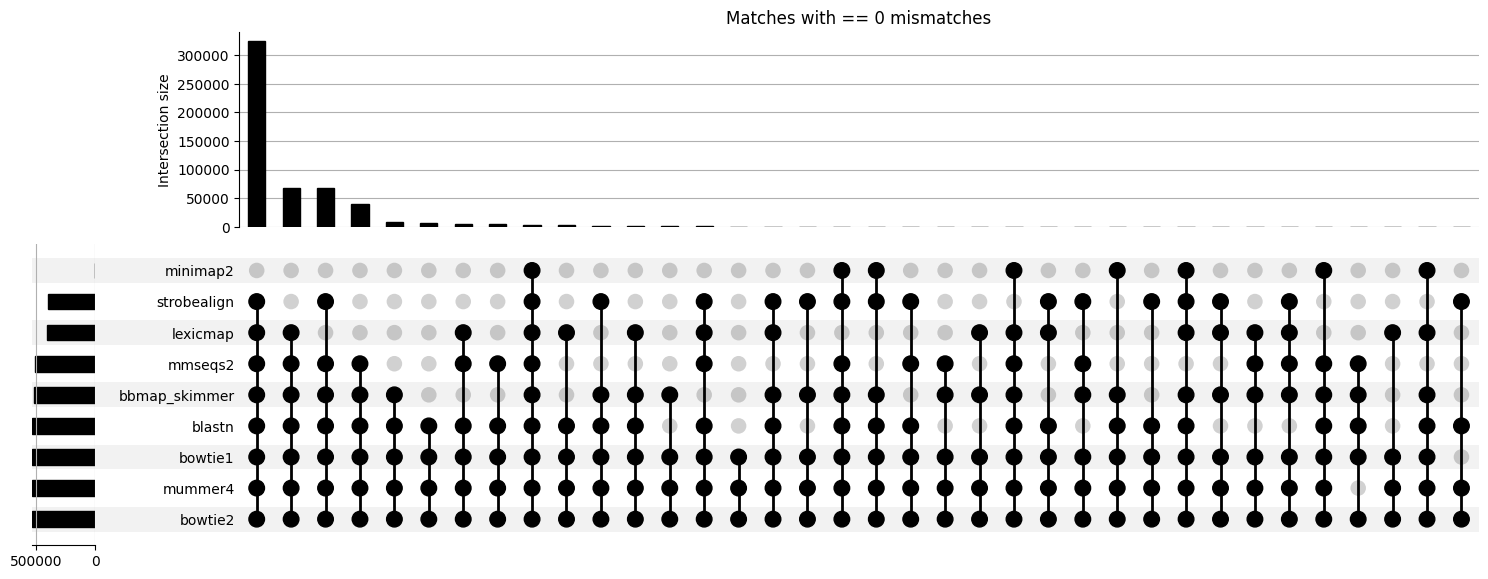

n mismatches:  1


<Figure size 1000x600 with 0 Axes>

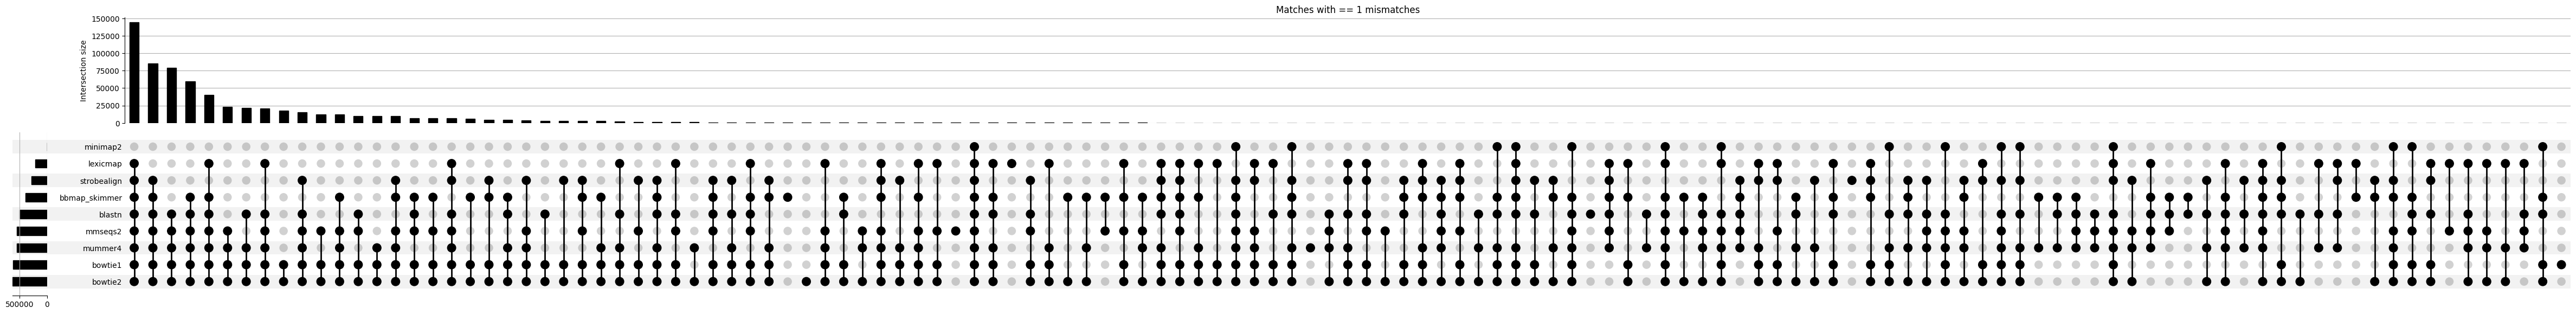

n mismatches:  2


<Figure size 1000x600 with 0 Axes>

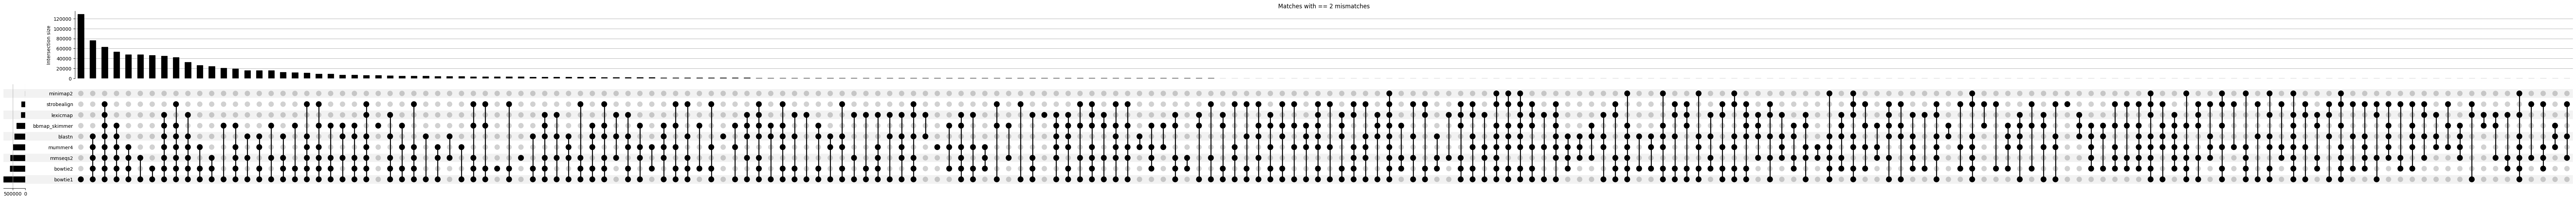

n mismatches:  3


<Figure size 1000x600 with 0 Axes>

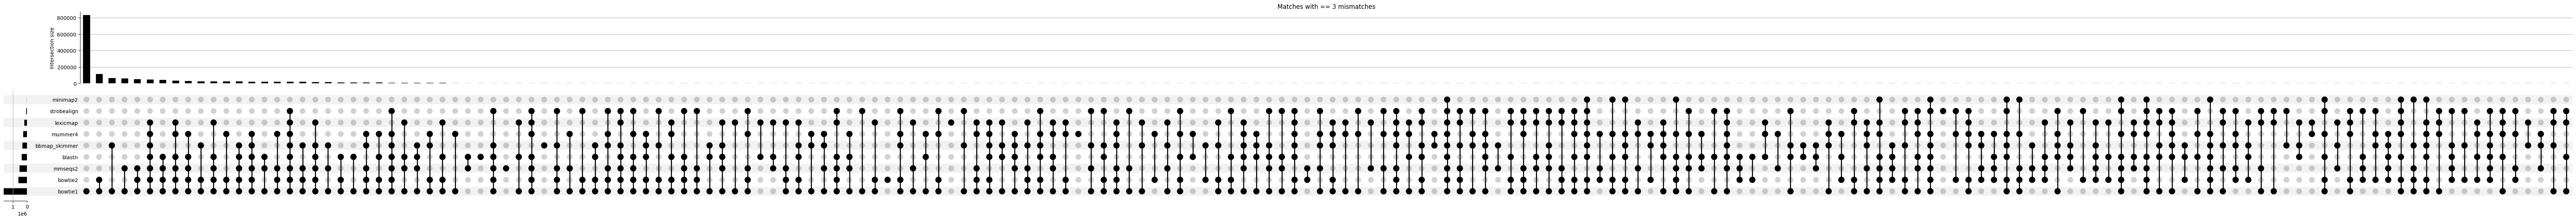

In [23]:
plot_mismatches = [0,1,2,3]
for n_mismatches in plot_mismatches: 
    # first we create a table where each row is a contig and a 2nd column is a list of tools that matched the contig
    nmism_tools_results = tools_results.filter(pl.col('mismatches') == n_mismatches)
    contig_tool_table = nmism_tools_results.group_by('contig_id').agg(pl.col('tool').unique().alias('tools')).sort('contig_id')
    test_upset = up.from_memberships(contig_tool_table['tools']) # need to disable future deprecation warrnings
    print("n mismatches: ", n_mismatches)
    plt.figure(figsize=(10, 6))
    up.plot(test_upset, subset_size='count',sort_by='cardinality')
    plt.title(f'Matches with == {n_mismatches} mismatches') #≤
    plt.savefig(f'results/real_data/plots/upset_{n_mismatches}.pdf')
    plt.show()

And as one figure for the supplementary material (I couldn't figure out how to merge upset plots, and I really do not want this to be done in inkscape manually, so using use svgutils)

In [8]:
# First create individual plots and save them
for i, n_mismatches in enumerate(plot_mismatches):
    # Create the data for the upset plot
    nmism_tools_results = tools_results.filter(pl.col('mismatches') == n_mismatches)
    contig_tool_table = nmism_tools_results.group_by('contig_id').agg(pl.col('tool').unique().alias('tools')).sort('contig_id')
    test_upset = up.from_memberships(contig_tool_table['tools'])
    
    # Create individual plot
    plt.figure(figsize=(12, 10))
    up.plot(test_upset, subset_size='count', sort_by='cardinality')
    plt.title(f'Matches with == {n_mismatches} mismatches')
    
    # Save individual plot
    plt.savefig(f'results/real_data/plots/upset_{n_mismatches}.svg', bbox_inches='tight')
    plt.close()


<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

In [86]:
# from svgutils.compose import Figure, Panel, SVG, Text
# height = f"2200"
# width = f"7500"
# fig = Figure(width, height,
#         SVG("results/real_data/plots/upset_0.svg",fix_mpl=True),
#         SVG("results/real_data/plots/upset_1.svg",fix_mpl=True),
#         SVG("results/real_data/plots/upset_2.svg",fix_mpl=True),
#         SVG("results/real_data/plots/upset_3.svg",fix_mpl=True)
#         ).tile(1, 4)
# fig.save("results/real_data/plots/upset_combined.svg")
# I can't figure out how to make this look good, will just point to the plots seperatly

#### Matrixes
In a tool vs tool manner, it possible to get specific insights.  
In the following tables A `cell(i,x)` is the number of unique spacer-contig pairs that are in tool `i` but not in tool `x`.   

In [13]:
all_charts = []
for n_mismatches in [0,1,2,3]:
    print(f"n_mismatches: {n_mismatches}")
    
    # Filter for current mismatch level
    tmp = tools_results.filter(pl.col('mismatches') == n_mismatches)
    
    # Create empty matrix
    matrix = pl.DataFrame(data=np.zeros((len(tools_list), len(tools_list)), dtype=int), schema=tools_list)
    
    # Get unique pairs for each tool
    tool_pairs = {}
    for tool in tools_list:
        tool_pairs[tool] = tmp.filter(pl.col('tool') == tool).select(["contig_id","spacer_id","strand","start","end"]).unique()
    
    # Fill matrix with counts
    for i, tool_x in enumerate(tools_list):
        for j, tool_y in enumerate(tools_list):
            if tool_x == tool_y:
                continue
            # Count pairs in x but not in y
            unique_pairs = tool_pairs[tool_x].join(tool_pairs[tool_y], on=['contig_id','spacer_id','strand','start','end'], how='anti')
            matrix[i,j] = unique_pairs.height
    
    # Convert to DataFrame for better visualization
    matrix = matrix.with_columns(pl.Series(name="tool1", values=tools_list, dtype=pl.Utf8))
    print(f"Matrix for {n_mismatches} mismatches:")
    print(matrix)
    heatmap_filename = f'results/real_data/plots/matrix_{n_mismatches}'
    chart = plot_matrix(matrix, f"Matrix for {n_mismatches} mismatches", heatmap_filename)
    all_charts.append(chart)
    # plot_matrix(matrix, f"Matrix for {n_mismatches} mismatches (% of tool's total matches)", heatmap_filename+"_percent", as_percent=True)  # as percentages
    matrix.write_csv(f'results/real_data/results/matrix_{n_mismatches}.tsv',separator='\t')
    print("\n")

n_mismatches: 0
Matrix for 0 mismatches:
shape: (9, 10)
┌─────────┬─────────┬────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┐
│ mmseqs2 ┆ bbmap_s ┆ blastn ┆ bowtie2 ┆ mummer4 ┆ bowtie1 ┆ strobea ┆ lexicma ┆ minimap ┆ tool1   │
│ ---     ┆ kimmer  ┆ ---    ┆ ---     ┆ ---     ┆ ---     ┆ lign    ┆ p       ┆ 2       ┆ ---     │
│ i64     ┆ ---     ┆ i64    ┆ i64     ┆ i64     ┆ i64     ┆ ---     ┆ ---     ┆ ---     ┆ str     │
│         ┆ i64     ┆        ┆         ┆         ┆         ┆ i64     ┆ i64     ┆ i64     ┆         │
╞═════════╪═════════╪════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╡
│ 0       ┆ 1310003 ┆ 12188  ┆ 162     ┆ 261     ┆ 38      ┆ 1163486 ┆ 1014680 ┆ 1581206 ┆ mmseqs2 │
│         ┆         ┆        ┆         ┆         ┆         ┆ 5       ┆ 3       ┆ 9       ┆         │
│ 517622  ┆ 0       ┆ 17719  ┆ 155     ┆ 7036    ┆ 34      ┆ 1081009 ┆ 9663985 ┆ 1501857 ┆ bbmap_s │
│         ┆         ┆        ┆     

Let's combine all the matrixes svgs into one for the manuscript

In [22]:
import altair as alt

row_1 = alt.hconcat(all_charts[0],all_charts[1])
row_2 = alt.hconcat(all_charts[2],all_charts[3])
chart = alt.vconcat(row_1,row_2)
chart.save("results/real_data/plots/matrix_combined.svg")
chart.save("results/real_data/plots/matrix_combined.pdf",format="pdf")
chart

alt.VConcatChart(...)

Summary of the matrixes: (one matrix with <=3 mismatches)

In [27]:
n_mismatches = 3
# Filter for current mismatch level
tmp = tools_results.filter(pl.col('mismatches') <= n_mismatches)

# Create empty matrix
matrix = pl.DataFrame(data=np.zeros((len(tools_list), len(tools_list)), dtype=int), schema=tools_list)

# Get unique pairs for each tool
tool_pairs = {}
for tool in tools_list:
    tool_pairs[tool] = tmp.filter(pl.col('tool') == tool).select(["contig_id","spacer_id","strand","start","end"]).unique()

# Fill matrix with counts
for i, tool_x in enumerate(tools_list):
    for j, tool_y in enumerate(tools_list):
        if tool_x == tool_y:
            continue
        # Count pairs in x but not in y
        unique_pairs = tool_pairs[tool_x].join(tool_pairs[tool_y], on=['contig_id','spacer_id','strand','start','end'], how='anti')
        matrix[i,j] = unique_pairs.height

# Convert to DataFrame for better visualization
matrix = matrix.with_columns(pl.Series(name="tool1", values=tools_list, dtype=pl.Utf8))
print(f"Matrix for {n_mismatches} mismatches:")
print(matrix)
heatmap_filename = f'results/real_data/plots/matrix__less_or_equal_3_mismatches'
chart = plot_matrix(matrix, f"Matrix <= {n_mismatches} mismatches", heatmap_filename)
# plot_matrix(matrix, f"Matrix for {n_mismatches} mismatches (% of tool's total matches)", heatmap_filename+"_percent", as_percent=True)  # as percentages
matrix.write_csv(f'results/real_data/results/matrix_less_or_equal_3_mismatches.tsv',separator='\t')
print("\n")
chart

Matrix for 3 mismatches:
shape: (9, 10)
┌─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬────────┐
│ mmseqs2 ┆ bbmap_s ┆ blastn  ┆ bowtie2 ┆ mummer4 ┆ bowtie1 ┆ strobea ┆ lexicma ┆ minimap ┆ tool1  │
│ ---     ┆ kimmer  ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ lign    ┆ p       ┆ 2       ┆ ---    │
│ i64     ┆ ---     ┆ i64     ┆ i64     ┆ i64     ┆ i64     ┆ ---     ┆ ---     ┆ ---     ┆ str    │
│         ┆ i64     ┆         ┆         ┆         ┆         ┆ i64     ┆ i64     ┆ i64     ┆        │
╞═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪════════╡
│ 0       ┆ 1904958 ┆ 1169896 ┆ 8420878 ┆ 1127152 ┆ 4427706 ┆ 3074945 ┆ 2950494 ┆ 3595216 ┆ mmseqs │
│         ┆ 5       ┆ 3       ┆         ┆ 8       ┆         ┆ 0       ┆ 4       ┆ 3       ┆ 2      │
│ 2240185 ┆ 0       ┆ 2952012 ┆ 922046  ┆ 2731893 ┆ 140032  ┆ 1409604 ┆ 1372144 ┆ 1914139 ┆ bbmap_ │
│         ┆         ┆         ┆         ┆         ┆

alt.LayerChart(...)

### 2. Tool comparison - spacer-contig pairs as a function of the number of occurrences 
Next, we check if an increase in the number of occurrences (meaning more of the same spacer in the reference file) corrosponds to a lower true positive rate (in the sense that the tools do not find as much). The exact effect should be tool specific.  

Next, for each spacer, we add a column that specifies the fraction of the occurrences that tool identified


In [6]:
def create_spacer_counts_with_tools(recalc_only, tools_list, mismatches=3, exact_or_max="exact"):
    # First get total occurrences per spacer across all tools
    if exact_or_max == "max":
        spacer_counts = recalc_only.filter(pl.col('mismatches') <= mismatches)
    else:
        spacer_counts = recalc_only.filter(pl.col('mismatches') == mismatches)
    
    spacer_counts = spacer_counts.select(["spacer_id", "contig_id"])\
        .unique()\
        .group_by('spacer_id')\
        .agg(pl.count('contig_id').alias('n_occurrences'))

    # Calculate matches per tool and spacer without joining to spacer_counts yet
    if exact_or_max == "max":
        tool_matches = recalc_only.filter(pl.col('mismatches') <= mismatches)
    else:
        tool_matches = recalc_only.filter(pl.col('mismatches') == mismatches)
    
    tool_matches = tool_matches.select(['spacer_id', 'tool', 'contig_id'])\
        .unique()\
        .group_by(['spacer_id', 'tool'])\
        .agg(pl.count('contig_id').alias('tool_matches'))

    # Create a cross join of all spacers with all tools
    all_combinations = spacer_counts.select('spacer_id', 'n_occurrences')\
        .join(
            pl.DataFrame({'tool': tools_list}),
            how='cross'
        )

    # Join the actual matches and calculate fractions
    complete_fractions = all_combinations\
        .join(
            tool_matches,
            on=['spacer_id', 'tool'],
            how='left'
        )\
        .with_columns([
            pl.col('tool_matches').fill_null(0),
            (pl.col('tool_matches') / pl.col('n_occurrences')).alias('fraction')
        ])

    # Pivot to get tools as columns
    spacer_counts_with_tools = complete_fractions\
        .pivot(
            index=['spacer_id', 'n_occurrences'],
            on='tool',
            values='fraction'
        )\
        .fill_null(0)
    
    return spacer_counts_with_tools

Recall plots vs occurrences

In [19]:
def plot_combined_recall_vs_occurrences(recalc_only, tools_list, n_high_occ_bins=3, 
                         output_prefix='results/real_data/plots/recall_vs_occurrences', 
                         max_bin=3, n_bins=150, color_dict=None, marker_dict=None, exact_or_max="exact",
                         plot_mismatches=[1,3]):
    
    # Create color and marker dictionaries for consistent styling
    import matplotlib.colors as mcolors
    if color_dict is None:
        color_dict = dict(zip(tools_list, mcolors.TABLEAU_COLORS))
    if marker_dict is None:
        marker_dict = dict(zip(tools_list, ['o', 's', '^', 'D', 'v', '<', '>', 'p','x']))

    # Create figure with two subplots
    fig, axes = plt.subplots(len(plot_mismatches), 1, figsize=(15, 36))
    
    for i, mismatches in enumerate(plot_mismatches):
        # Create a new figure for the single plot
        fig_single, ax_single = plt.subplots(figsize=(15, 12))
        
        # Plot on both the combined and single figures
        plot_on_axis(axes[i], recalc_only, tools_list, n_high_occ_bins, n_bins, max_bin, 
                    mismatches=mismatches, exact_or_max=exact_or_max, color_dict=color_dict, 
                    marker_dict=marker_dict, output_prefix=output_prefix)
        plot_on_axis(ax_single, recalc_only, tools_list, n_high_occ_bins, n_bins, max_bin, 
                    mismatches=mismatches, exact_or_max=exact_or_max, color_dict=color_dict, 
                    marker_dict=marker_dict, output_prefix=output_prefix)
        
        # Set titles
        if exact_or_max == "exact":
            title = f'Recall vs number of occurrences (mismatches == {mismatches})'
        else:
            title = f'Recall vs number of occurrences (mismatches ≤ {mismatches})'
        axes[i].set_title(title)
        ax_single.set_title(title)
        
        # Save single plot
        plt.figure(fig_single.number)
        plt.tight_layout()
        fig_single.savefig(f'{output_prefix}_{exact_or_max}_nm_{mismatches}.pdf', bbox_inches='tight',format='pdf')
        fig_single.savefig(f'{output_prefix}_{exact_or_max}_nm_{mismatches}.svg', bbox_inches='tight',format='svg')
        plt.close(fig_single)
    
    # Save combined plot
    plt.figure(fig.number)
    plt.tight_layout()
    plot_mismatches_str = "_".join([str(mismatch) for mismatch in plot_mismatches])
    fig.savefig(f'{output_prefix}_{exact_or_max}_nm_{plot_mismatches_str}_combined.pdf', bbox_inches='tight')
    fig.savefig(f'{output_prefix}_{exact_or_max}_nm_{plot_mismatches_str}_combined.svg', bbox_inches='tight')
    plt.show()

def plot_on_axis(ax: plt.Axes, recalc_only, tools_list, n_high_occ_bins, n_bins, max_bin, 
                 mismatches, exact_or_max, color_dict, marker_dict,output_prefix):
    
    spacer_counts_with_tools = create_spacer_counts_with_tools(recalc_only, tools_list, 
                                                             mismatches=mismatches, 
                                                             exact_or_max=exact_or_max)

    # Create range bins for number of occurrences
    bins = np.logspace(np.log10(1), max_bin, n_bins)

    # Calculate mean fraction for each tool within each bin
    bin_stats = []
    for i in range(len(bins)-1):
        mask = (spacer_counts_with_tools['n_occurrences'] >= bins[i]) & \
               (spacer_counts_with_tools['n_occurrences'] < bins[i+1])
        bin_data = spacer_counts_with_tools.filter(mask)
        if bin_data.height > 0:
            stats = {
                'bin_start': bins[i],
                'bin_end': bins[i+1],
                'n_spacers': bin_data.height
            }
            for tool in tools_list:
                stats[tool] = bin_data[tool].mean()
            bin_stats.append(stats)

    # Add points for high occurrences in multiple bins
    if n_high_occ_bins > 0:
        high_occ_edges = np.logspace(3, 4, n_high_occ_bins + 1)
        for i in range(n_high_occ_bins):
            bin_start = high_occ_edges[i]
            bin_end = high_occ_edges[i + 1]
            
            if i == n_high_occ_bins - 1:
                high_occ_mask = (spacer_counts_with_tools['n_occurrences'] >= bin_start)
            else:
                high_occ_mask = (spacer_counts_with_tools['n_occurrences'] >= bin_start) & \
                               (spacer_counts_with_tools['n_occurrences'] < bin_end)
            
            high_occ_data = spacer_counts_with_tools.filter(high_occ_mask)
            if high_occ_data.height > 0:
                high_occ_stats = {
                    'bin_start': bin_start,
                    'bin_end': bin_end,
                    'n_spacers': high_occ_data.height
                }
                for tool in tools_list:
                    high_occ_stats[tool] = high_occ_data[tool].mean()
                bin_stats.append(high_occ_stats)

    # Plot on the provided axis
    for tool in tools_list:
        x = [(stat['bin_start'] + stat['bin_end'])/2 for stat in bin_stats]
        y = [stat[tool] for stat in bin_stats]
        ax.plot(x, y, label=tool, markersize=4, linewidth=1, 
                color=color_dict[tool], markerfacecolor=color_dict[tool],
                marker=marker_dict[tool])

    ax.set_xscale('log')
    ax.set_xlabel('Number of occurrences (log scale)')
    ax.set_ylabel('Mean Detection Fraction')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.grid(True, which="major", ls="-", alpha=0.5)
    ax.minorticks_on()
    ax.set_ylim(0, 1.05)
    ax.set_xlim(1, 10**4)
    

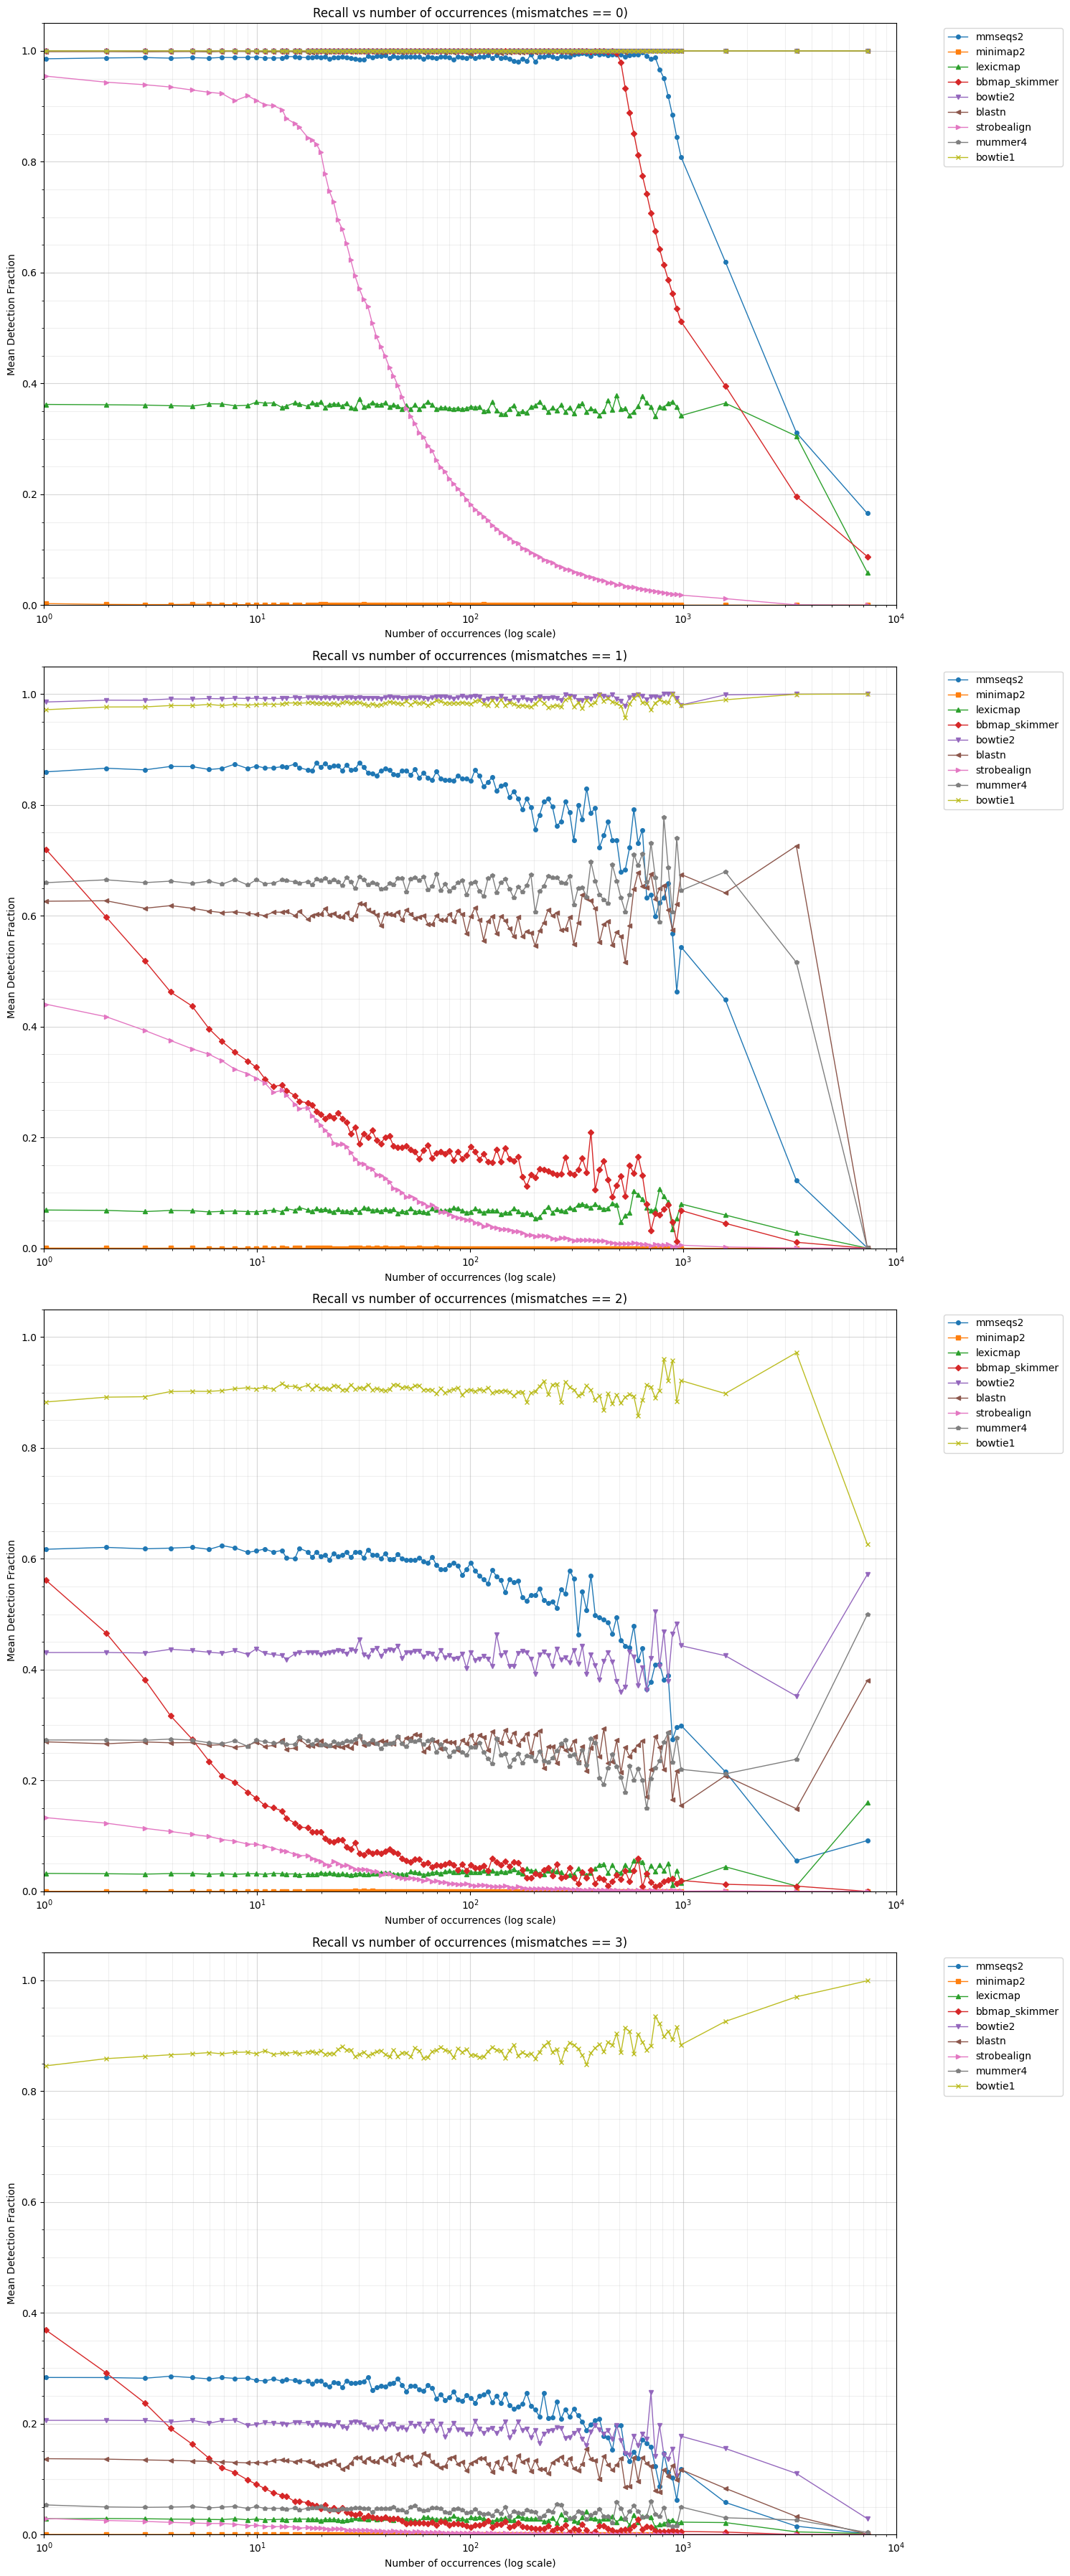

In [ ]:
n_mismatches = [0,1,2,3]
plot=plot_combined_recall_vs_occurrences(tools_results,
                                        tools_list,
                                        n_high_occ_bins=3,
                                        output_prefix=f'results/real_data/plots/recall_vs_occurrences',
                                        plot_mismatches=n_mismatches,
                                        exact_or_max="exact")



And in a multi-panel plot with 2 plots (up to 1 and up to 3):

In [21]:
tools_list

['mmseqs2',
 'minimap2',
 'lexicmap',
 'bbmap_skimmer',
 'bowtie2',
 'blastn',
 'strobealign',
 'mummer4',
 'bowtie1']

Similar plots, but with 1 and 3 mismatches (max, not exact), and in a multi-panel plot (for the main text)

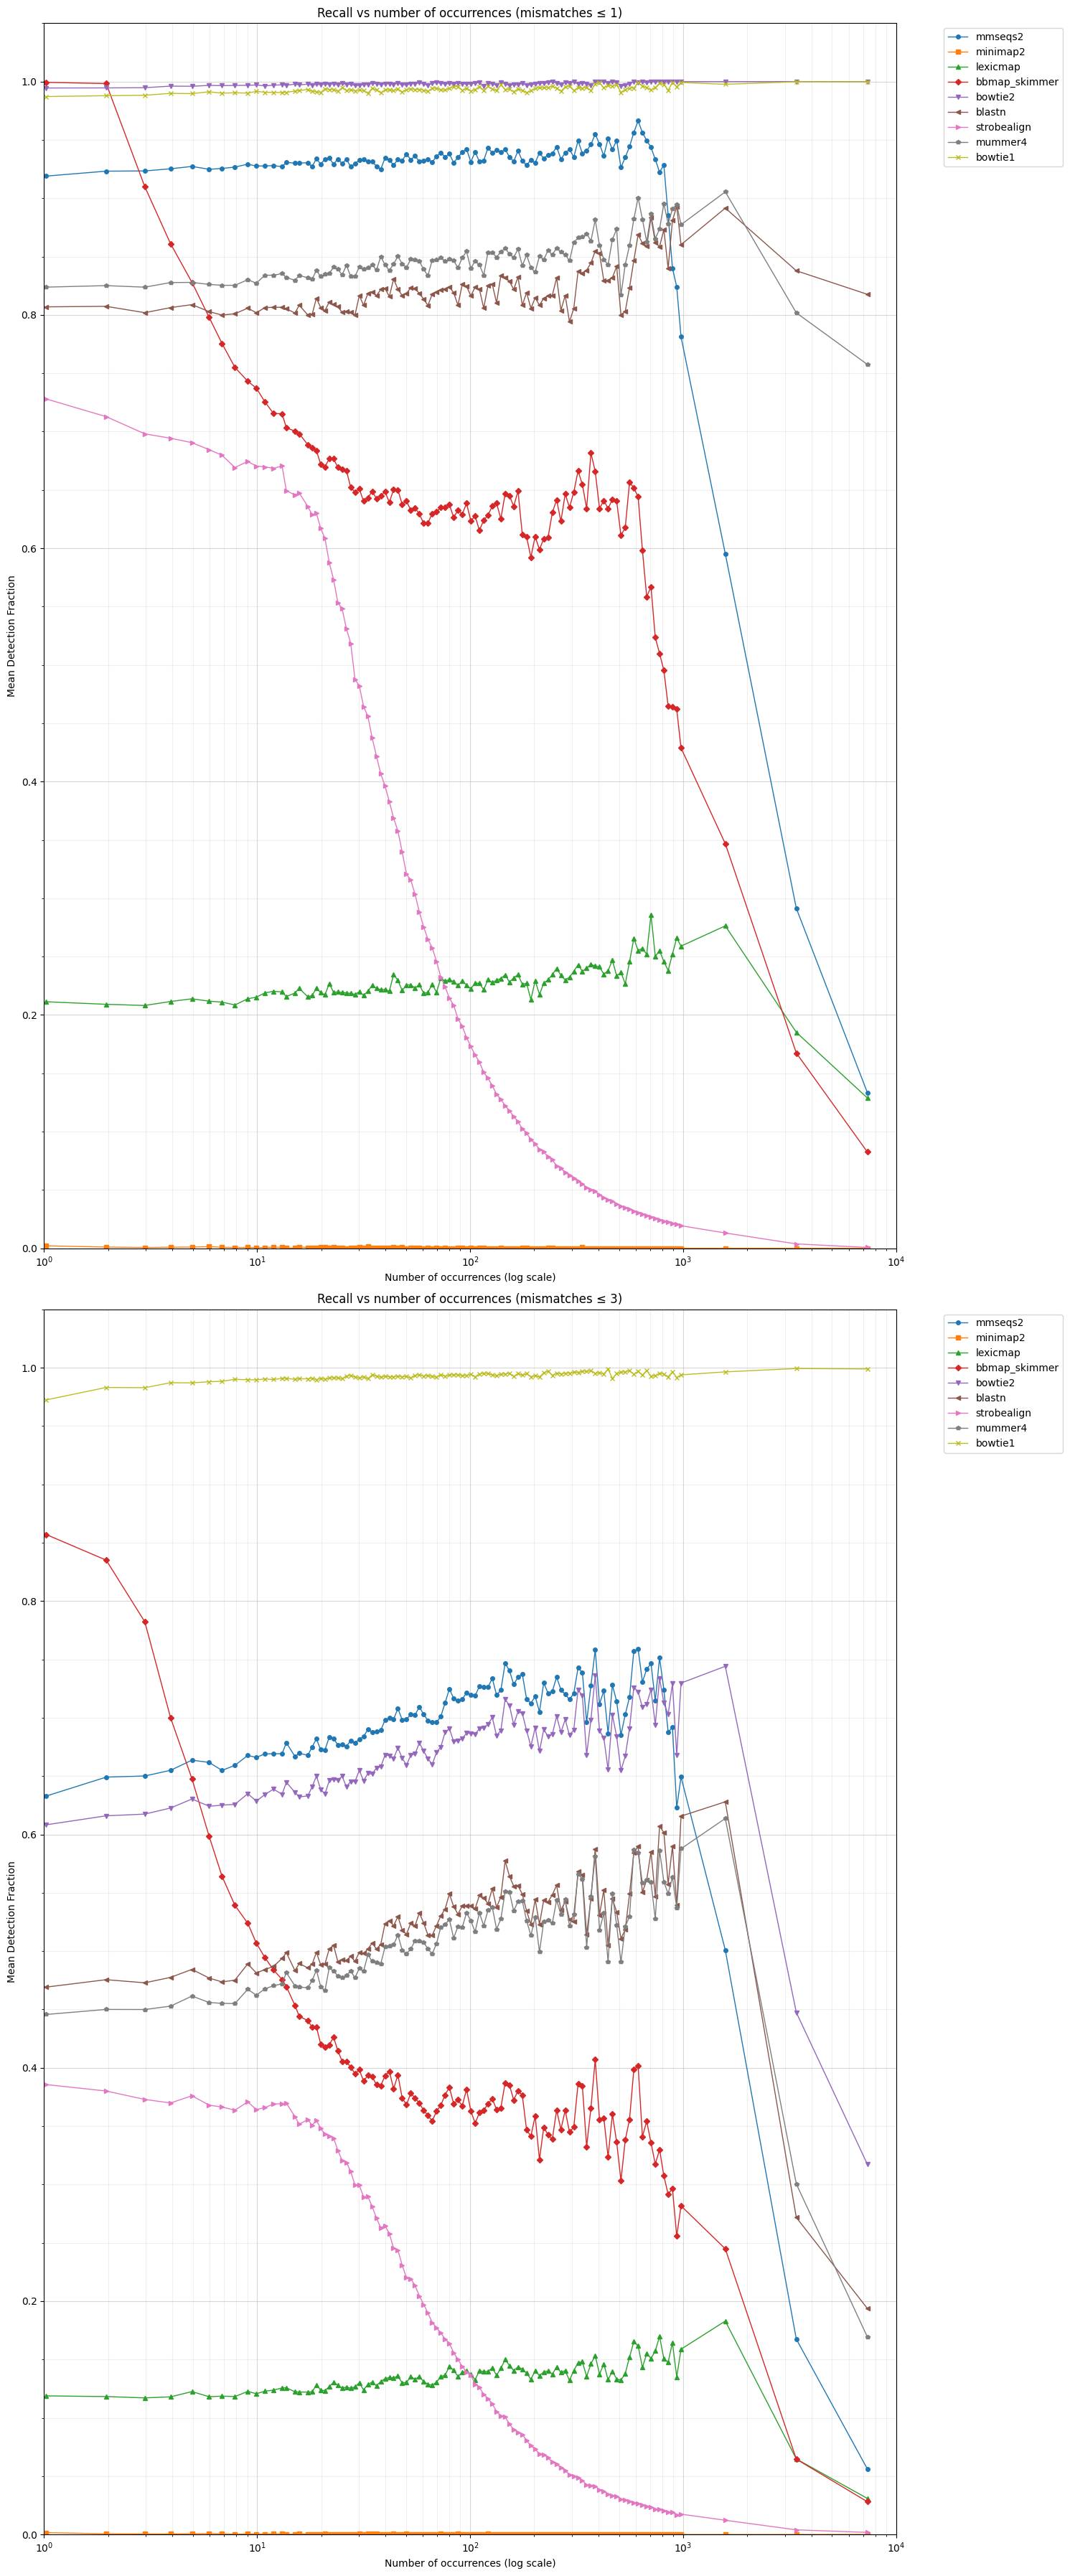

In [22]:
# Call the plotting function combined
plot_combined_recall_vs_occurrences(tools_results, tools_list, n_high_occ_bins=3, 
                                  output_prefix='results/real_data/plots/recall_vs_occurrences',
                                  exact_or_max="max",
                                  plot_mismatches=[1,3])

Next, we'll look at the performance of the tools as a function of the number of mismatches.

In [25]:
# First calculate the total matches per spacer-contig pair across all tools (per mismatch level)
import altair as alt
total_matches = tools_results\
    .select(['spacer_id', 'contig_id', 'mismatches'])\
    .unique()\
    .group_by(['mismatches'])\
    .agg(pl.len().alias('total_possible'))

# Calculate matches per tool at each mismatch level
tool_matches = tools_results\
    .select(['spacer_id', 'contig_id', 'tool', 'mismatches'])\
    .unique()\
    .group_by(['mismatches', 'tool'])\
    .agg(pl.len().alias('tool_matches'))

# Create all combinations of mismatches (0-3) and tools
all_combinations = pl.DataFrame({
    'mismatches': np.repeat(range(4), len(tools_list)),
    'tool': tools_list * 4
})

# Calculate fractions
mismatch_performance = all_combinations\
    .join(
        total_matches,
        on='mismatches'
    )\
    .join(
        tool_matches,
        on=['mismatches', 'tool'],
        how='left'
    )\
    .with_columns([
        pl.col('tool_matches').fill_null(0),
        (pl.col('tool_matches') / pl.col('total_possible')).alias('recall')
    ])

mismatch_performance.write_csv('results/real_data/results/tool_recall_by_mismatches.tsv',separator='\t')

metrics = {
    # 'precision': 'true_positives / (true_positives + false_positives)',
    'recall': 'true_positives / (true_positives + false_negatives)',
    # 'f1_score': ' 2 * (precision * recall) / (precision + recall)'
}

charts = []

for metric in metrics.keys():
    base_chart = alt.Chart(mismatch_performance).mark_trail(color="tool:N").encode(
        x=alt.X("mismatches:Q", title="Number of Mismatches"),
        y=alt.Y(f"{metric}:Q", 
                title=metrics[metric],
                scale=alt.Scale(domain=[0, 1.05])
                ),
        color=alt.Color("tool:N",
                        legend=None
                       ),  # Hide color legend
        shape=alt.Shape("tool:N",     # Shape legend will show both shape and color
                       legend=alt.Legend(
                           title="Tool",
                           orient="right",
                           symbolFillColor="tool:N",  # Use the color encoding for fill
                           symbolStrokeColor="tool:N" # Use the color encoding for stroke
                       )),
        tooltip=['tool', 'mismatches', metric]
    ).properties(
        width=300,
        height=300,
        title=metric.title()
    )
    
    charts.append(base_chart)

# Combine charts horizontally
combined_chart = alt.hconcat(*charts).configure_axis(
    grid=True,
    gridOpacity=0.9
).configure_view(step=1,
    strokeWidth=0.1
).configure_title(
    fontSize=16,
    anchor='middle'
)
combined_chart.save('./results/real_data/plots/tool_performance_by_mismatches.html')
combined_chart.save('./results/real_data/plots/tool_performance_by_mismatches.json',format='json')

import json as json
# Save the chart specification as JSON with the correct format
chart_json = combined_chart.to_json(format="vega")

# Parse the JSON
chart_spec = json.loads(chart_json)

# Replace the legends in the specification
# We'll need to traverse the spec to find where legends are defined damn it
def update_legends_in_spec(spec):
    # Define the new legend configuration
    new_legend = {
    "orient": "right",
    "symbolSize": 190,
    "symbolOpacity": 1,
    "symbolFillColor": "shape",
    "symbolStrokeColor": "tool:N",
    "title": "Tool",
    "shape": "shape",
    "fill": "color",
    "offset": 0,
    "encode": {
        "symbols": {
            "update": {
                "fillOpacity": {"value": 0.9}
            }
        }
    }}
    if isinstance(spec, dict):
        if 'legends' in spec:
            spec['legends'] = [new_legend]
        for value in spec.values():
            update_legends_in_spec(value)
    elif isinstance(spec, list):
        for item in spec:
            update_legends_in_spec(item)
    return spec

new_chart_spec = update_legends_in_spec(chart_spec)

# Write the modified specification to a file
def change_chart_spec(new_chart_spec,output_path):
        html_content = f"""
        <!DOCTYPE html>
        <html>
        <head>
        <script src="https://cdn.jsdelivr.net/npm/vega@5"></script>
        <script src="https://cdn.jsdelivr.net/npm/vega-lite@5"></script>
        <script src="https://cdn.jsdelivr.net/npm/vega-embed@6"></script>
        </head>
        <body>
        <div id="vis"></div>
        <script type="text/javascript">
            var spec = {json.dumps(new_chart_spec)};
            vegaEmbed('#vis', spec);
        </script>
        </body>
        </html>
        """
        
        with open(output_path, 'w') as f:
            f.write(html_content)
# chart_spec
change_chart_spec(new_chart_spec, './results/real_data/plots/tool_performance_by_mismatches.html')


In [26]:
combined_chart

alt.HConcatChart(...)

In [27]:
spacer_counts_with_tools = create_spacer_counts_with_tools(tools_results, tools_list, mismatches=3,exact_or_max="max")

Now we chart the distribution of the spacer lengths, number of mismatches, and number of occurrences.

In [36]:
# alt.data_transformers.enable("vegafusion")
def plot_spacer_distributions(tools_results, spacer_counts_with_tools, output_prefix='results/real_data/plots'):
    """Create a three-panel figure showing spacer length, mismatch, and occurrence distributions using Altair.
    Uses VegaFusion for efficient handling of large datasets.
    """
    # Pre-aggregate in Polars to reduce data size
    spacer_df = tools_results.select([
        'spacer_id', 'contig_id', 'strand', 'start', 'end', 'spacer_length', 'mismatches'
    ]).unique()

    occurrence_df = spacer_counts_with_tools['n_occurrences'].value_counts()
    mismatches_df=spacer_df['mismatches'].value_counts()
    length_df=spacer_df['spacer_length'].value_counts()

   
    # Base chart for occurrence distribution
    base = alt.Chart(occurrence_df).encode(
        tooltip=['n_occurrences:Q', 'count:Q']
    )

    chart3 = base.mark_bar(opacity=0.5).encode(
        alt.X('n_occurrences:Q',
                scale=alt.Scale(type='log'),
                title='Number of Occurrences'),
        alt.Y('count:Q', title='Count (Linear Scale)')
    ).properties(
        title='B.',
    )
    
    chart1 = alt.Chart(length_df).mark_bar().encode(
        x=alt.X('spacer_length:Q', title='Spacer Length (bp)', axis=alt.Axis(grid=True,tickCount=100)),
        y=alt.Y("count:Q", axis=alt.Axis(title="Number of Spacers", grid=True,ticks=False,gridDash=[2,2]),
        # scale=alt.Scale(domain=[16, 108])
        )

        
    ).properties(
        title='A.',
    )

    chart2 = alt.Chart(mismatches_df).mark_bar(width=13).encode(
        x=alt.X('mismatches:Q', title='Number of Mismatches', axis=alt.Axis(grid=True,tickCount=6)),
        y=alt.Y("count:Q", axis=alt.Axis(title="Number of Spacers",  grid=True,ticks=False,gridDash=[2,2])),
        # color=alt.Color('mismatches:Q', legend=T)
    ).properties(
        title='C.',
    )
    
    combined_chart = chart1 | chart3 | chart2
    combined_chart  = combined_chart.configure_title(anchor='start')
    return combined_chart


In [40]:
combined_chart =  plot_spacer_distributions(spacer_counts_with_tools=spacer_counts_with_tools,tools_results=tools_results)


In [41]:
combined_chart

alt.HConcatChart(...)

In [42]:

combined_chart.save('./results/real_data/plots/spacer_distributions.html')
combined_chart.save('./results/real_data/plots/spacer_distributions.svg',format='svg')
combined_chart.save('./results/real_data/plots/spacer_distributions.pdf',format='pdf')


In [43]:
combined_chart

alt.HConcatChart(...)

For safe keeping, also print some summary statistics

In [33]:
# Print some summary statistics
# plot_spacer_distributions(spacer_counts_with_tools=spacer_counts_with_tools,tools_results=tools_results)
print("\nSummary Statistics:")
print("\nSpacer Lengths:")
print(f"Mean: {tools_results['spacer_length'].mean():.2f}")
print(f"Median: {tools_results['spacer_length'].median():.2f}")
print(f"Std: {tools_results['spacer_length'].std():.2f}")
print(f"Min: {tools_results['spacer_length'].min()}")
print(f"Max: {tools_results['spacer_length'].max()}")

print("\nMismatches:")
print(f"Mean: {tools_results['mismatches'].mean():.2f}")
print(f"Median: {tools_results['mismatches'].median():.2f}")
print(f"Std: {tools_results['mismatches'].std():.2f}")
print(f"Min: {tools_results['mismatches'].min()}")
print(f"Max: {tools_results['mismatches'].max()}")

print("\nOccurrences:")
print(f"Mean: {spacer_counts_with_tools['n_occurrences'].mean():.2f}")
print(f"Median: {spacer_counts_with_tools['n_occurrences'].median():.2f}")
print(f"Std: {spacer_counts_with_tools['n_occurrences'].std():.2f}")
print(f"Min: {spacer_counts_with_tools['n_occurrences'].min()}")
print(f"Max: {spacer_counts_with_tools['n_occurrences'].max()}")


Summary Statistics:

Spacer Lengths:
Mean: 32.83
Median: 33.00
Std: 2.69
Min: 25
Max: 100

Mismatches:
Mean: 0.90
Median: 1.00
Std: 1.05
Min: 0
Max: 3

Occurrences:
Mean: 44.67
Median: 7.00
Std: 149.65
Min: 1
Max: 14012


Finnaly, we'll targz the plots folder in the results folder for easy download/sharing 

In [35]:
%%bash
tar -czvf results/real_data/plots.tar.gz results/real_data/plots 

results/real_data/plots/
results/real_data/plots/matrix_0.html
results/real_data/plots/matrix_0.svg
results/real_data/plots/matrix_1.html
results/real_data/plots/matrix_1.svg
results/real_data/plots/matrix_2.html
results/real_data/plots/matrix_2.svg
results/real_data/plots/matrix_3.html
results/real_data/plots/matrix_3.svg
results/real_data/plots/matrix__less_or_equal_3_mismatches.html
results/real_data/plots/matrix__less_or_equal_3_mismatches.svg
results/real_data/plots/matrix_combined.pdf
results/real_data/plots/matrix_combined.svg
results/real_data/plots/recall_vs_occurrences_combined.svg
results/real_data/plots/recall_vs_occurrences_exact_N_mismatches_0_.pdf
results/real_data/plots/recall_vs_occurrences_exact_N_mismatches_0_bin_stats.tsv
results/real_data/plots/recall_vs_occurrences_exact_N_mismatches_1_.pdf
results/real_data/plots/recall_vs_occurrences_exact_N_mismatches_1_bin_stats.tsv
results/real_data/plots/recall_vs_occurrences_exact_N_mismatches_2_.pdf
results/real_data/plots